In [ ]:
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import pandas as pd
import scipy

import scienceplots
plt.style.use('science')

plt.rcParams.update({'font.size': 11})

In [2]:
h = mr.MesaData("15Msol/LOGS_15Msun/history.data")

### Q.21.

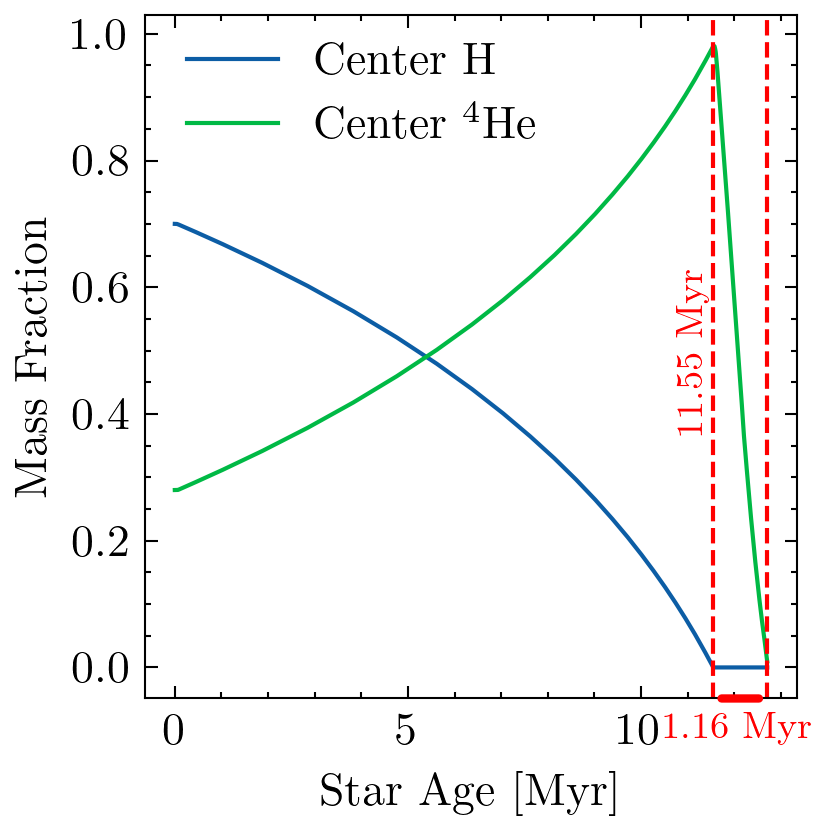

In [71]:
duration_hydrogen = 11.55
duration_helium = 1.16

fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)

ax.plot(h.star_age / 1e6, h.center_h1, label=r'Center H', color='C0')
ax.plot(h.star_age / 1e6, h.center_he4, label=r'Center $^4$He', color='C1')

ax.axvline(duration_hydrogen, color='red', linestyle='--', linewidth=1)
ax.text(duration_hydrogen - 0.8, 0.5, f'~{duration_hydrogen} Myr', color='red', rotation=90, va='center', ha='left', fontsize=9)

ax.axvline(duration_hydrogen + duration_helium, color='red', linestyle='--', linewidth=1)

x1 = duration_hydrogen
x2 = duration_hydrogen + duration_helium
y_pos = 0.05
ax.annotate(
    '', xy=(x2, y_pos - .099), xytext=(x1, y_pos - .099),
    arrowprops=dict(arrowstyle='-', color='red', lw=2)
)
ax.text((x1 + x2) / 2, y_pos - .12, f'${duration_helium}$ Myr', color='red', ha='center', va='top', fontsize=9)

ax.set_xlabel('Star Age [Myr]')
ax.set_ylabel('Mass Fraction')

fig.legend(loc='upper left', bbox_to_anchor=(0.2, .96))

fig.savefig('../plots/q31center_h_he.pdf', bbox_inches='tight')

### Q.2.2

In [69]:
from io import StringIO

data = """alpha_ov	t_core_h_burn_in_Myr	t_core_He_burn_in_Myr
0.100	11.39	1.14
0.286	12.69	0.88
0.103	11.367	1.20
0.184	12.02	1.00
0.111	11.49	1.11
0.181	11.92	1.10
0.147	11.72	1.14
0.186	12.03	1.01
0.147		
0.121	11.55	1.16
0.261		
0.223	12.28	0.97
0.250235	12.46	0.94
0.1726	11.93	1.03
0.137	11.46	1.12
0.10014	11.399	1.13
0.2999	12.7	0.91
0.248	12.4	1.05
        
0.278	12.65	0.89
0.188		
"""

df_ov = pd.read_csv(StringIO(data), sep='\t')
df_ov = df_ov.dropna()
df_ov = df_ov[(df_ov != 0).all(axis=1)]
df_ov.reset_index(drop=True, inplace=True)

In [70]:
df_ov

,alpha_ov,t_core_h_burn_in_Myr,t_core_He_burn_in_Myr
0,0.100000,11.390,1.14
1,0.286000,12.690,0.88
2,0.103000,11.367,1.20
3,0.184000,12.020,1.00
4,0.111000,11.490,1.11
5,0.181000,11.920,1.10
6,0.147000,11.720,1.14
7,0.186000,12.030,1.01
8,0.121000,11.550,1.16
9,0.223000,12.280,0.97


In [ ]:
def lin_model(x, a, b):
    return a * x + b

# Fit for H core burning
p_h, pcov_h = scipy.optimize.curve_fit(
    lin_model, df_ov["alpha_ov"], df_ov["t_core_h_burn_in_Myr"]
)
x_fit = np.linspace(df_ov["alpha_ov"].min(), df_ov["alpha_ov"].max(), 100)
y_fit_h = lin_model(x_fit, *p_h)
errs_h = np.sqrt(np.diag(pcov_h))

# Fit for He core burning
p_he, pcov_he = scipy.optimize.curve_fit(
    lin_model, df_ov["alpha_ov"], df_ov["t_core_He_burn_in_Myr"]
)
y_fit_he = lin_model(x_fit, *p_he)
errs_he = np.sqrt(np.diag(pcov_he))

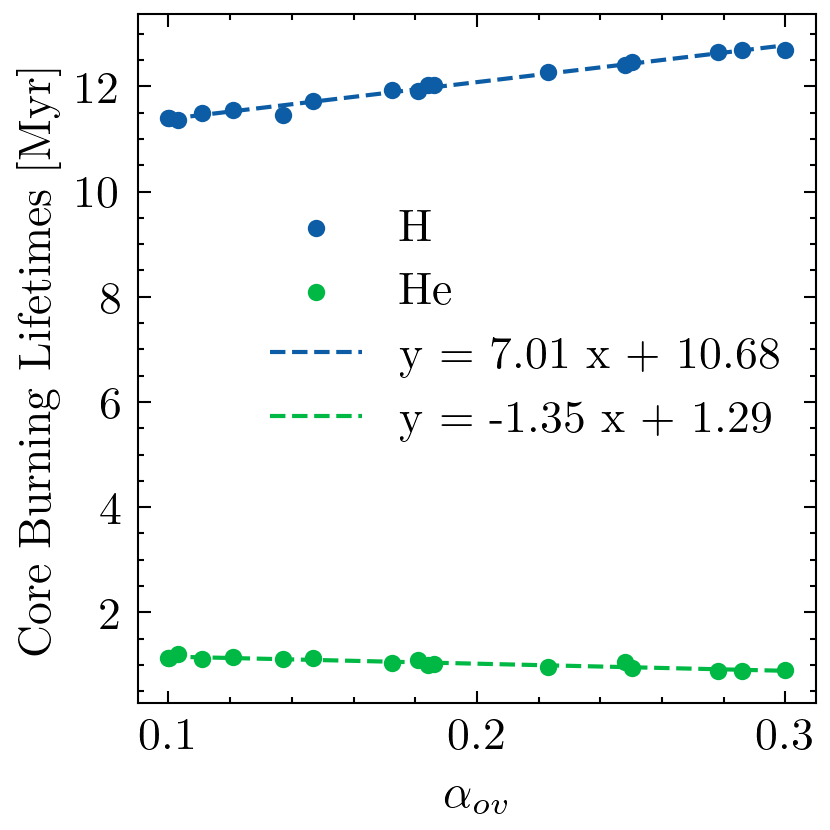

In [96]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)

ax.scatter(df_ov["alpha_ov"], df_ov["t_core_h_burn_in_Myr"], label="H", marker="o", s=10)
ax.scatter(df_ov["alpha_ov"], df_ov["t_core_He_burn_in_Myr"], label="He", marker="o", s=10)

label_h = f"y = {p_h[0]:.2f} x + {p_h[1]:.2f}"
label_he = f"y = {p_he[0]:.2f} x + {p_he[1]:.2f}"

ax.plot(x_fit, y_fit_h, color='C0', linestyle='--', label=label_h)
ax.plot(x_fit, y_fit_he, color='C1', linestyle='--', label=label_he)

ax.set_xlabel(r'$\alpha_{ov}$')
ax.set_ylabel('Core Burning Lifetimes [Myr]')
fig.legend(loc='center right', bbox_to_anchor=(.95, 0.6))

fig.savefig('../plots/q31core_burning_lifetime.pdf', bbox_inches='tight')

### Q3.4.

In [ ]:
def hydrogen_exhausted(X_c):
    return X_c < 1e-6

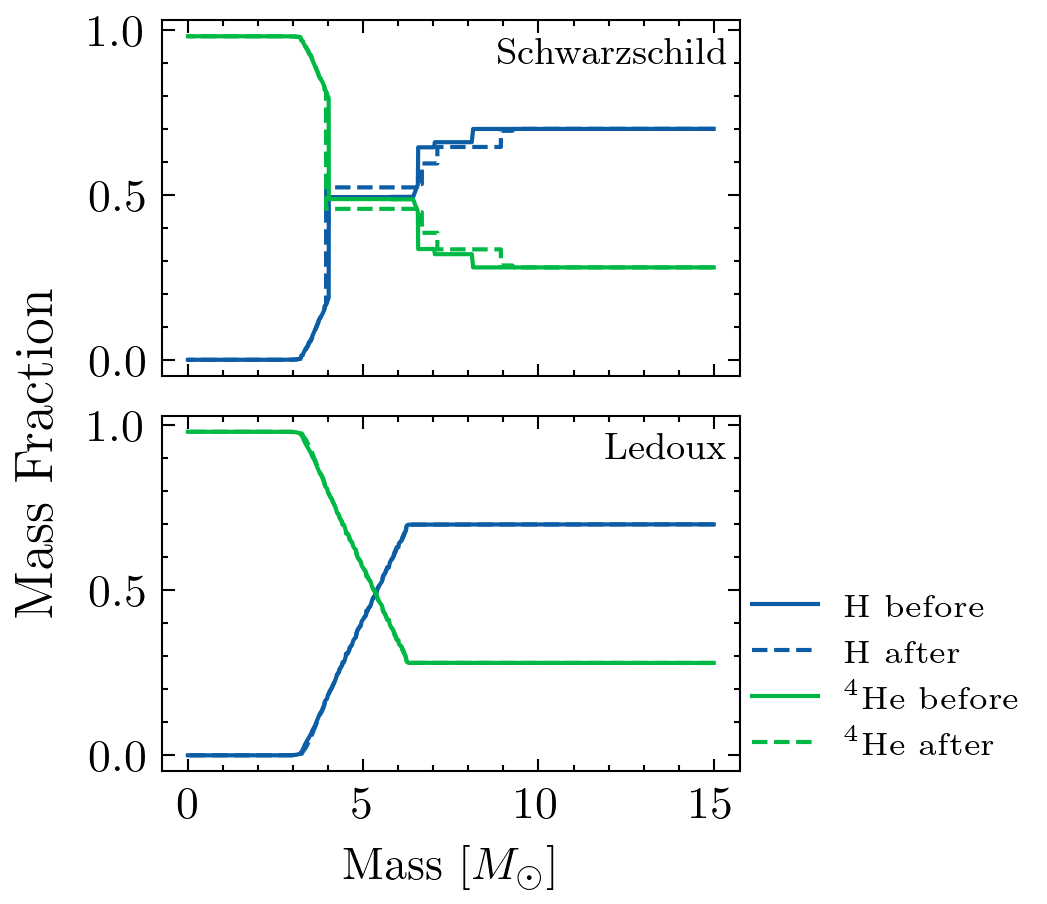

In [156]:
paths_to_models = ["15Msol/LOGS_15Msun", "15Msol_ledoux/LOGS_15Msun_Ledoux"]
labels = ['Schwarzschild', 'Ledoux']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 3), dpi=300, sharex=True, layout='constrained')

for i, path in enumerate(paths_to_models):
    l = mr.MesaLogDir(path)
    m_nums = l.select_models(hydrogen_exhausted, "center_h1")
    before = l.profile_data(model_number=m_nums[0])
    after = l.profile_data(model_number=m_nums[1])

    axs[i].plot(before.mass, before.x_mass_fraction_H, color='C0', label=r'H before')
    axs[i].plot(after.mass, after.x_mass_fraction_H, color='C0', linestyle='--', label=r'H after')
    axs[i].plot(before.mass, before.y_mass_fraction_He, color='C1', label=r'$^4$He before')
    axs[i].plot(after.mass, after.y_mass_fraction_He, color='C1', linestyle='--', label=r'$^4$He after')
    axs[i].text(0.98, 0.95, labels[i], ha='right', va='top', transform=axs[i].transAxes, fontsize=9)

axs[-1].set_xlabel('Mass [$M_\\odot$]')

handles, legend_labels = axs[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='center left', fontsize=7.9, frameon=False, bbox_to_anchor=(0.96, .25))

fig.supylabel('Mass Fraction')

fig.savefig('../plots/q34hydrogen_exhausted.pdf', bbox_inches='tight')